### colab에서 실행할시 아래꺼 실행

In [4]:
!apt-get install -y fonts-nanum*
!rm -rf /root/.cache/matplotlib/* # 폰트 캐시 재설정, 런타임 재시작도 할 것!

# Step1. 데이터 로딩과 기본 구조 확인

In [1]:
pip install missingno

In [6]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 추가 라이브러리 (설치 필요)
import missingno as msno
from statsmodels.tsa.seasonal import STL
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram

# 데이터 읽기
train_df = pd.read_csv('train.csv')
sample_sub = pd.read_csv('sample_submission.csv')

# 기본 정보
print("Shape:", train_df.shape)
print(train_df.dtypes)
display(train_df.head())

# unique item_id, 기간 확인
print("Unique item_id:", train_df['item_id'].nunique())
train_df['date'] = pd.to_datetime(train_df['year'].astype(str) + '-' + train_df['month'].astype(str).str.zfill(2))
print(train_df['date'].min(), "→", train_df['date'].max())

Shape: (10836, 9)
item_id      object
year          int64
month         int64
seq         float64
type          int64
hs4           int64
weight      float64
quantity    float64
value       float64
dtype: object


,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0
3,XIPPENFQ,2022,1,1.0,1,2501,20426.0,0.0,11172.0
4,FTSVTTSR,2022,1,1.0,1,2529,248000.0,0.0,143004.0


Unique item_id: 100
2022-01-01 00:00:00 → 2025-07-01 00:00:00


# Step2. 결측치 및 0값 분석

          missing_count  missing_ratio
item_id               0            0.0
year                  0            0.0
month                 0            0.0
seq                   0            0.0
type                  0            0.0
hs4                   0            0.0
weight                0            0.0
quantity              0            0.0
value                 0            0.0
date                  0            0.0
0 values in value: 5.8693%
0 values in weight: 8.6286%
0 values in quantity: 82.3090%


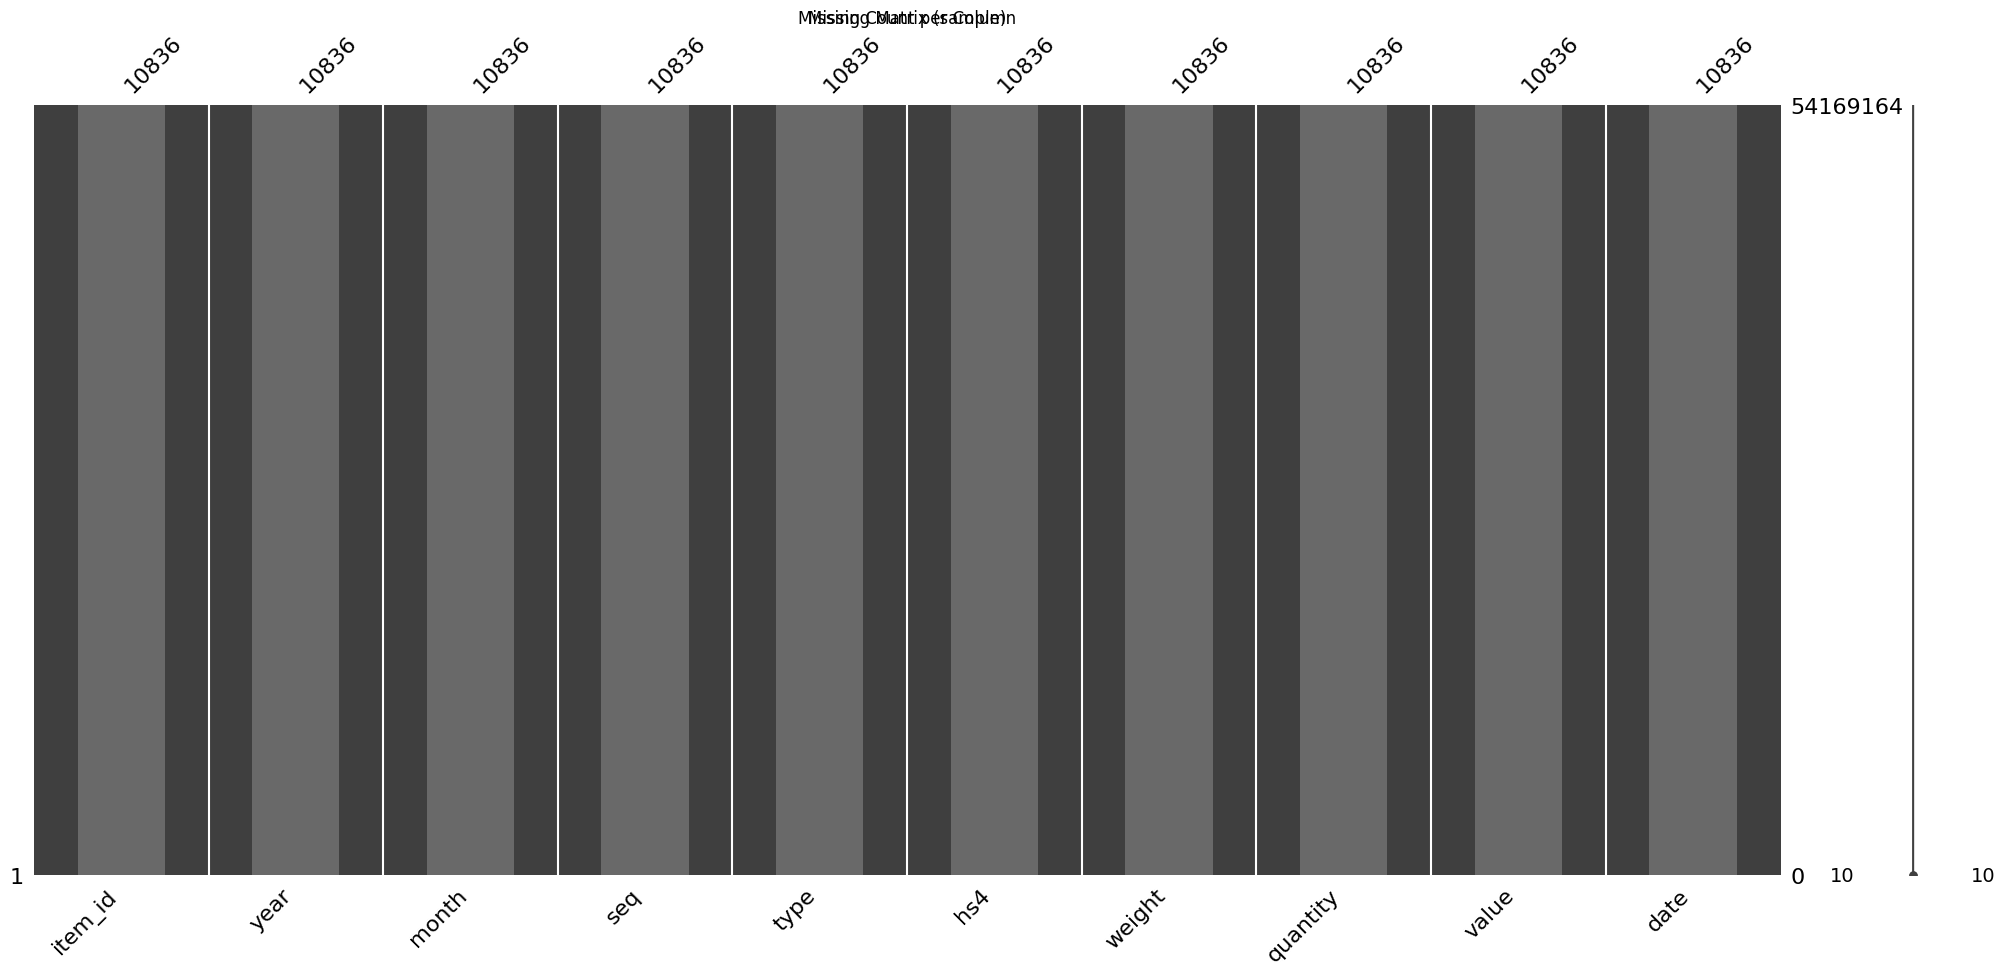

In [7]:
# 결측치 요약
missing_summary = train_df.isnull().sum().to_frame(name='missing_count')
missing_summary['missing_ratio'] = missing_summary['missing_count'] / len(train_df)
print(missing_summary)

# missingno 시각화
msno.matrix(train_df.sample(5000))
plt.title("Missing Matrix (sample)")

msno.bar(train_df)
plt.title("Missing Count per Column")

# 0값 비율 확인 (value, weight, quantity)
for col in ['value', 'weight', 'quantity']:
    zero_ratio = (train_df[col] == 0).mean()
    print(f'0 values in {col}: {zero_ratio:.4%}')


# Step3. 기술통계 및 분포 시각화

,count,mean,std,min,25%,50%,75%,max
value,10836.0,1.739442e+06,5.457480e+06,0.0,11506.75,125007.0,1039763.50,111041383.0
weight,10836.0,1.098413e+06,5.153790e+06,0.0,345.75,6532.5,155510.75,110491899.0
quantity,10836.0,8.633771e+04,7.614669e+06,0.0,0.00,0.0,0.00,792598955.0


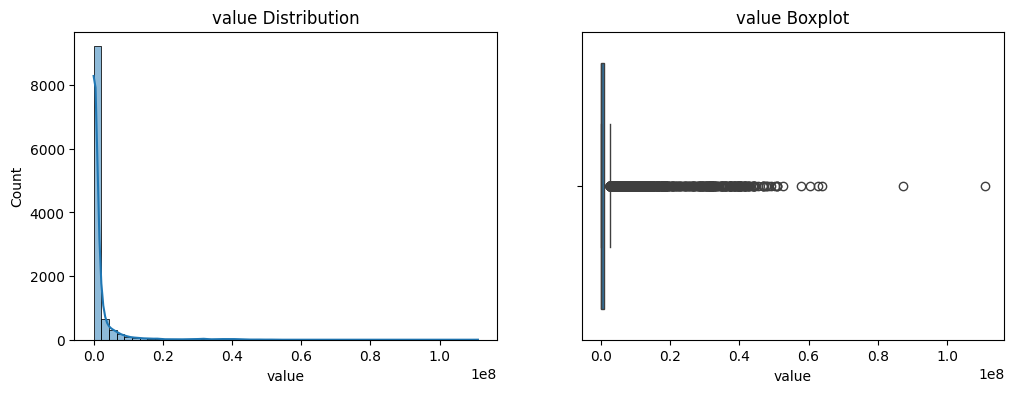

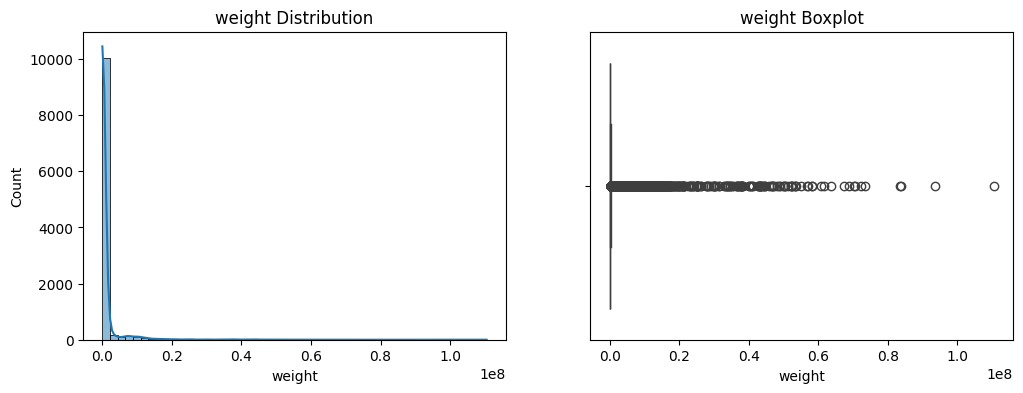

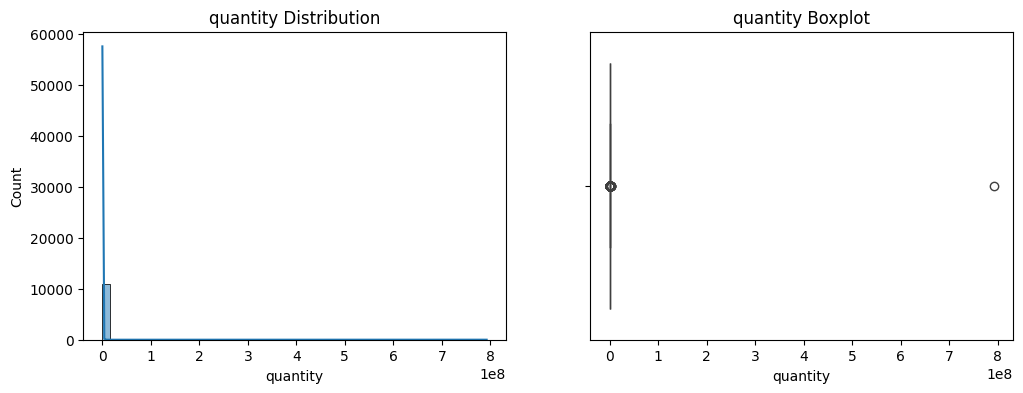

In [8]:
# 수치형 컬럼 기술통계
num_cols = ['value', 'weight', 'quantity']
display(train_df[num_cols].describe().T)

# 히스토그램과 상자그림
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(train_df[col], bins=50, ax=axes[0], kde=True)
    axes[0].set_title(f'{col} Distribution')
    sns.boxplot(x=train_df[col], ax=axes[1])
    axes[1].set_title(f'{col} Boxplot')
    plt.show()

# Step4. 시계열 구조: 트렌드, 계절성, 변동성

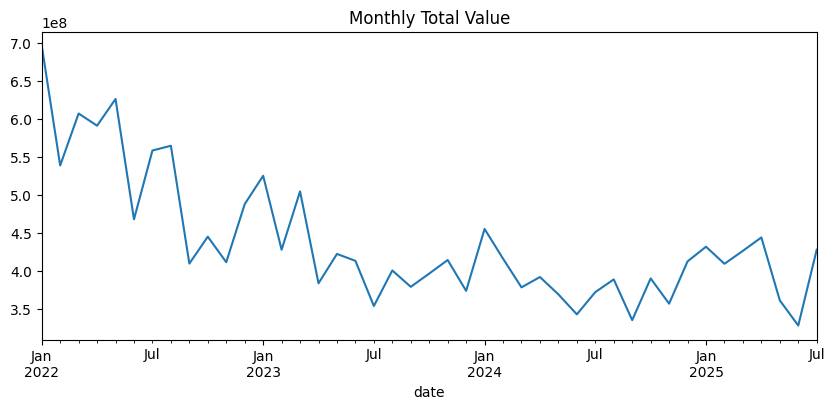

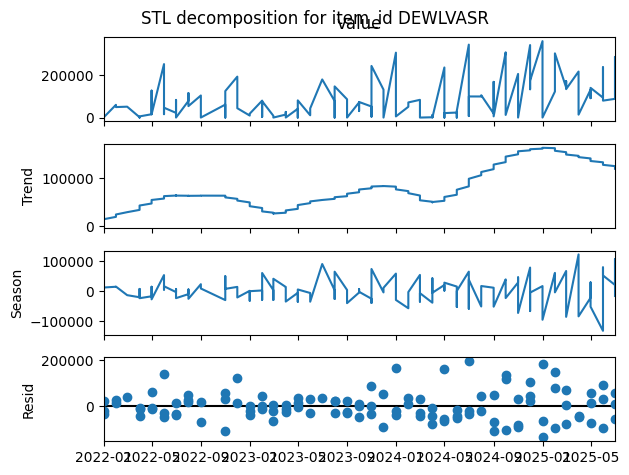

item_id
ATLDMDBO    11235985.0
FCYBOAXC     7527268.0
LRVGFDFM     4686809.0
STZDBITS     3079300.5
GYHKIVQT     2972162.0
GKQIJYDH     2517098.5
BTMOEMEP     2059576.0
SDWAYPIK     1613250.5
KFQSHBNH     1425285.0
CCLHWFWF     1406753.0
Name: value_diff, dtype: float64


In [9]:
# 월별 총합 확인
monthly_sum = train_df.groupby('date')['value'].sum()
monthly_sum.plot(figsize=(10,4), title='Monthly Total Value')
plt.show()

# STL 분해 (seasonal-trend decomposition) — 샘플로 한 품목 선택
sample_item = train_df['item_id'].unique()[0]
sample_series = train_df[train_df['item_id']==sample_item].set_index('date')['value']
stl = STL(sample_series, period=12)
res = stl.fit()
res.plot()
plt.suptitle(f'STL decomposition for item_id {sample_item}')
plt.show()

# 변동성: 월별 절댓값 변화량 요약
train_df['value_diff'] = train_df.groupby('item_id')['value'].diff().abs()
volatility = train_df.groupby('item_id')['value_diff'].median().sort_values(ascending=False)
print(volatility.head(10))

# Step5. 상관관계 및 클러스터링

        item_i    item_j      corr
6641  RJCAXSGH  KFQSHBNH  0.907683
4166  KFQSHBNH  RJCAXSGH  0.907683
9134  XIIEJNEE  IGDVVKUD  0.819554
3491  IGDVVKUD  XIIEJNEE  0.819554
6172  QRKRBYJL  SDWAYPIK  0.794249
7261  SDWAYPIK  QRKRBYJL  0.794249
6361  QVLMOEYE  QRKRBYJL  0.790776
6163  QRKRBYJL  QVLMOEYE  0.790776
6182  QRKRBYJL  VBYCLTYZ  0.779633
8261  VBYCLTYZ  QRKRBYJL  0.779633
6382  QVLMOEYE  VBYCLTYZ  0.773035
8263  VBYCLTYZ  QVLMOEYE  0.773035
9417  XUOIQPFL  DNMPSKTB  0.754678
1794  DNMPSKTB  XUOIQPFL  0.754678
417   ATLDMDBO  DNMPSKTB  0.713218
1704  DNMPSKTB  ATLDMDBO  0.713218
9404  XUOIQPFL  ATLDMDBO  0.707539
494   ATLDMDBO  XUOIQPFL  0.707539
9178  XIIEJNEE  UGEQLMXM  0.705846
7891  UGEQLMXM  XIIEJNEE  0.705846


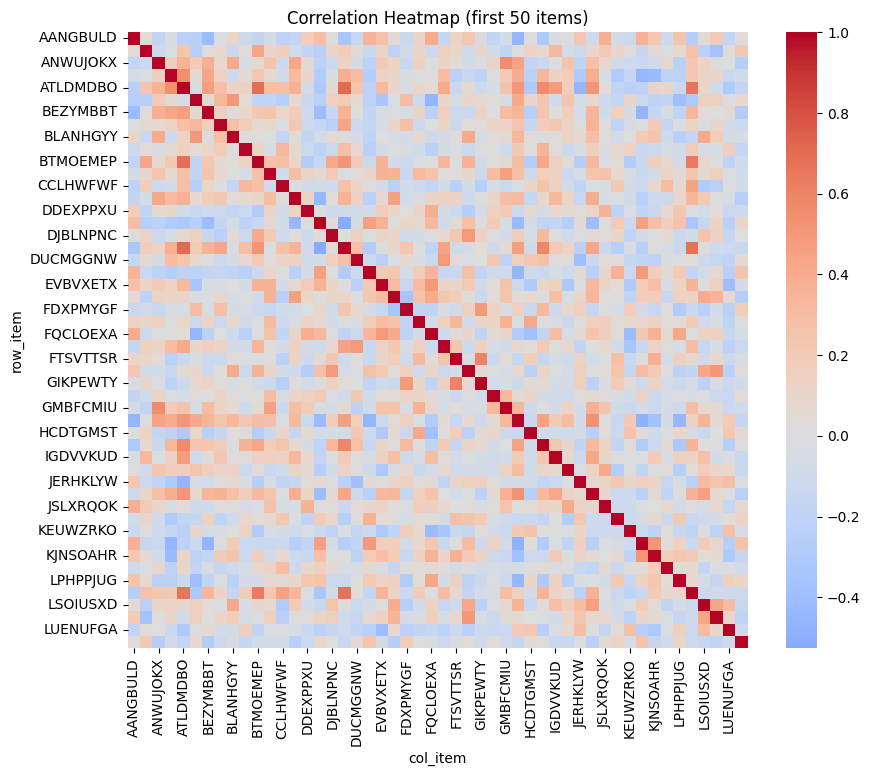

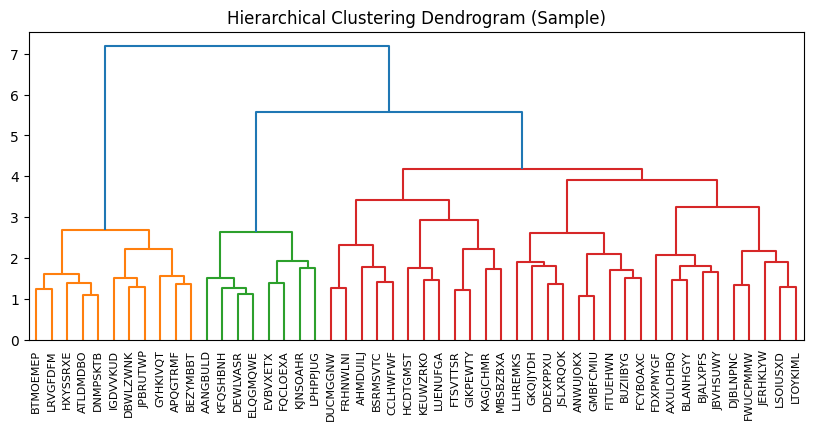

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

# 날짜(행) x item_id(열) 피벗테이블 생성
pivot_value = train_df.pivot_table(
    index='date', columns='item_id', values='value', aggfunc='sum', fill_value=0
)

# 상관행렬 계산
corr_matrix = pivot_value.corr()

# Index와 Columns 이름 충돌 방지
corr_matrix.index.name = 'row_item'
corr_matrix.columns.name = 'col_item'

# 상관관계 (i,j) 쌍 추출
corr_pairs = corr_matrix.unstack().dropna().reset_index()
corr_pairs.columns = ['item_i', 'item_j', 'corr']

# 동일 품목(i=j) 제거 후 상위 20개 강한 양/음 상관관계
high_corr = corr_pairs.loc[
    corr_pairs['item_i'] != corr_pairs['item_j']
].sort_values(by='corr', ascending=False).head(20)
print(high_corr)

# 히트맵 (상관행렬 일부)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.iloc[:50, :50], cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (first 50 items)')
plt.show()

# 계층적 군집화 덴드로그램 (샘플 50개)
corr_sample = corr_matrix.iloc[:50, :50]
# corr_sample은 DataFrame이므로 numpy array로 변환
linked = linkage(corr_sample.values, method='ward')
plt.figure(figsize=(10, 4))
dendrogram(linked, labels=corr_sample.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Sample)')
plt.show()

# Step6. HS4 코드 기반 품목 그룹 분석

,value
hs4,
FCYB,4.671997e+09
ATLD,2.579887e+09
GYHK,1.456760e+09
CCLH,1.081998e+09
STZD,1.057606e+09
LRVG,8.040184e+08
BUZI,7.404158e+08
BTMO,7.049946e+08
GKQI,6.070892e+08


,mean,std
hs4,,
FCYB,3.621703e+07,6.011104e+06
ATLD,2.063909e+07,1.746949e+07
GYHK,1.129271e+07,5.984646e+06
CCLH,8.387579e+06,4.137830e+06
STZD,8.198496e+06,5.020414e+06
LRVG,6.281394e+06,8.409538e+06
BUZI,5.739657e+06,1.145088e+06
BTMO,5.465075e+06,4.222104e+06
GKQI,4.706118e+06,6.593394e+06


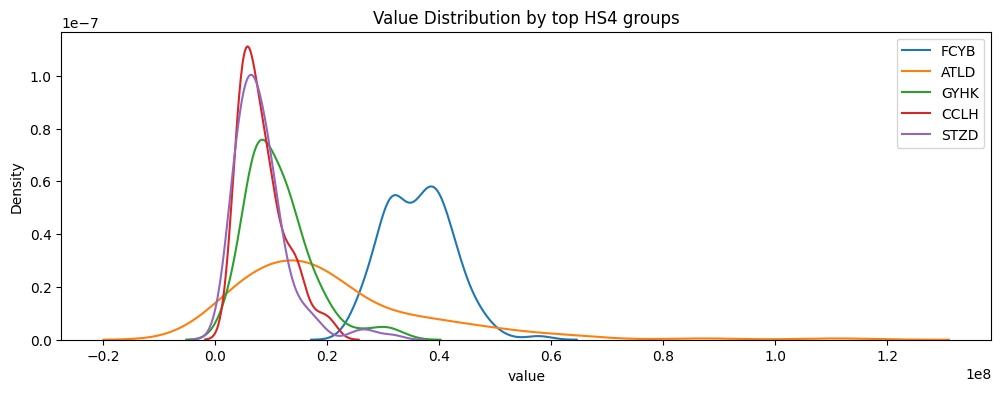

In [11]:
# HS4 코드 추출 (예: item_id 앞 4자리)
train_df['hs4'] = train_df['item_id'].str[:4]
hs4_sum = train_df.groupby('hs4')['value'].sum().sort_values(ascending=False)
display(hs4_sum.head(20))

# HS4 그룹별 평균 및 표준편차
hs4_stats = train_df.groupby('hs4')['value'].agg(['mean','std']).sort_values(by='mean', ascending=False)
display(hs4_stats.head(20))

# HS4 그룹별 분포 시각화 (상위 5개)
top5_hs4 = hs4_sum.head(5).index
plt.figure(figsize=(12,4))
for code in top5_hs4:
    sns.kdeplot(train_df[train_df['hs4']==code]['value'], label=code)
plt.title("Value Distribution by top HS4 groups")
plt.legend()
plt.show()

# Step7. 간선 그래프와 노드 중심성 분석

간선 수: 5375


,item_id,in_degree,out_degree,closeness,betweenness
95,YSYHGLQK,14.173036,9.800788,0.682759,0.890229
84,VUAFAIYJ,16.152524,14.081806,0.692308,0.886415
71,SAHWCZNH,19.628663,18.001374,0.727941,0.818079
94,XUOIQPFL,23.796487,25.860655,0.767442,0.810864
19,ELQGMQWE,18.367429,21.896467,0.727941,0.742321
24,FQCLOEXA,19.783659,21.491685,0.761538,0.709338
32,HCDTGMST,13.994575,15.924218,0.668919,0.700577
59,QJQJSWFU,20.093307,16.826496,0.785714,0.667491
74,STZDBITS,11.655973,9.391513,0.634615,0.593177
1,AHMDUILJ,13.037862,13.319036,0.660000,0.589569


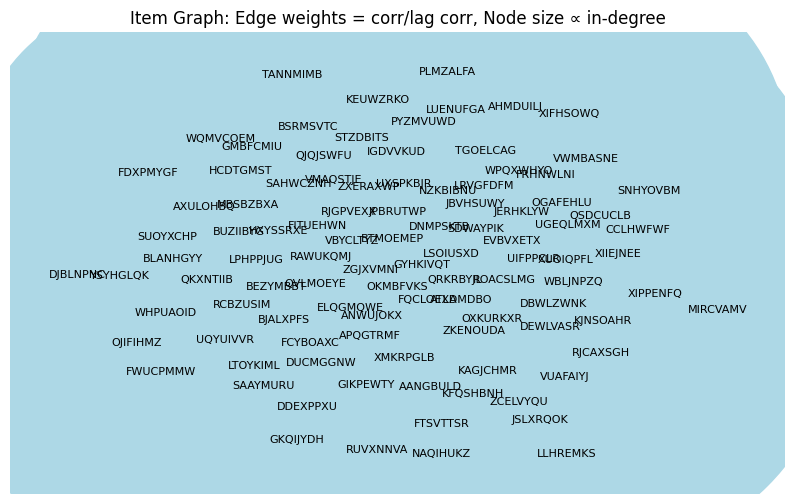

In [16]:
# (사전에 train_df와 pivot_tbl, item_ids, N_ITEMS 등이 정의되어 있어야 함)

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1) 피벗: 날짜(행) x item_id(열)
pivot_tbl = train_df.pivot_table(index='date', columns='item_id', values='value', aggfunc='sum', fill_value=0)

# 2) 상관계수 기반 가중치
corr_matrix = pivot_tbl.corr()
corr_threshold = 0.3  # 상관계수 임계값
lag_threshold  = 0.2  # 시차 cross corr 임계값

# cross-correlation 함수
def max_lag_corr(a, b, max_lag=3):
    a = a - a.mean()
    b = b - b.mean()
    max_corr = 0.0
    for lag in range(1, max_lag+1):
        if len(a) <= lag: break
        c = np.corrcoef(a[:-lag], b[lag:])[0, 1]
        max_corr = max(max_corr, abs(c))
    return max_corr

# 3) 그래프 생성
G = nx.DiGraph()
items = corr_matrix.columns.tolist()

for i_idx, item_i in enumerate(items):
    for j_idx, item_j in enumerate(items):
        if i_idx == j_idx:
            continue
        w_static = corr_matrix.loc[item_i, item_j]
        # 시차 기반 cross-corr (단방향)
        w_lag = max_lag_corr(pivot_tbl[item_i].values, pivot_tbl[item_j].values, max_lag=3)
        # static 관계
        if abs(w_static) >= corr_threshold:
            G.add_edge(item_i, item_j, weight=float(w_static))
        # lag 관계
        if w_lag >= lag_threshold:
            G.add_edge(item_i, item_j, weight=float(w_lag))

print(f"간선 수: {G.number_of_edges()}")

# 중심성 계산
in_deg   = dict(G.in_degree(weight='weight'))
out_deg  = dict(G.out_degree(weight='weight'))
closenes = nx.closeness_centrality(G)
between  = nx.betweenness_centrality(G, weight='weight')

centrality_df = pd.DataFrame({
    'item_id'    : items,
    'in_degree'  : [in_deg.get(it,0.0) for it in items],
    'out_degree' : [out_deg.get(it,0.0) for it in items],
    'closeness'  : [closenes.get(it,0.0) for it in items],
    'betweenness': [between.get(it,0.0) for it in items],
})
display(centrality_df.sort_values(by='betweenness', ascending=False).head(10))

# 네트워크 시각화 (노드 크기는 in_degree, 엣지 두께는 weight)
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx_nodes(G, pos, node_size=[5000*(in_deg.get(n,0.01)) for n in G.nodes], node_color='lightblue')
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray', arrowsize=5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Item Graph: Edge weights = corr/lag corr, Node size ∝ in-degree")
plt.axis('off')
plt.show()

# Step8. 부호(signed signal) 및 무역량 움직임 범위 기반 패턴 분석

Top 10 patterns by frequency:
-B+D+D 7
-A+E+E 4
+C-C-C 4
-C-C+C 3
+D+C-B 2
+D+D-B 2
+C+D-B 2
-B-B-C 1
+C+C-C 1
-C+C+C 1


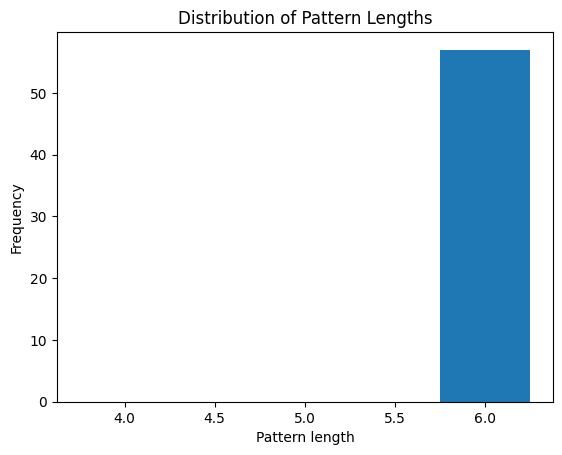

In [17]:
# 1) 월별 전월 대비 차이 및 상대적 변화율 계산
train_df['value_shift'] = train_df.groupby('item_id')['value'].shift(1)
train_df['value_change'] = train_df['value'] - train_df['value_shift']
train_df['change_sign'] = train_df['value_change'].apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')

# 2) 변화 범위 구간화 (예시: 5개 구간)
quantiles = train_df['value_change'].quantile([0.1, 0.3, 0.7, 0.9]).values
def categorize_change(x):
    if pd.isna(x):
        return 'N'
    if x <= quantiles[0]:
        return 'A'  # 급락
    elif x <= quantiles[1]:
        return 'B'  # 소폭 하락
    elif x <= quantiles[2]:
        return 'C'  # 거의 비슷
    elif x <= quantiles[3]:
        return 'D'  # 소폭 상승
    else:
        return 'E'  # 급상승

train_df['change_range'] = train_df['value_change'].apply(categorize_change)

# 3) 6개월 청크별 패턴 문자열 생성
chunk_size = 6
patterns = []
for item in train_df['item_id'].unique():
    item_series = train_df[train_df['item_id']==item].sort_values('date')
    chars = item_series['change_sign'] + item_series['change_range']
    # 패턴 추출
    for i in range(0, len(chars), chunk_size):
        chunk = ''.join(chars.iloc[i : i+chunk_size])
        if len(chunk)==chunk_size:
            patterns.append(chunk)

# 4) 패턴 빈도 분석
from collections import Counter
pattern_counts = Counter(patterns)
# 상위 10개 패턴 출력
print("Top 10 patterns by frequency:")
for pat, cnt in pattern_counts.most_common(10):
    print(pat, cnt)

# 5) 패턴 길이 분포 시각화
import matplotlib.pyplot as plt
lens = [len(pat) for pat in patterns]
plt.hist(lens, bins=range(chunk_size-2, chunk_size+2), align='left', rwidth=0.5)
plt.title("Distribution of Pattern Lengths")
plt.xlabel("Pattern length")
plt.ylabel("Frequency")
plt.show()

In [18]:
item_series

,item_id,year,month,seq,type,hs4,weight,quantity,value,date,value_diff,value_shift,value_change,change_sign,change_range
9134,RJCAXSGH,2025,1,1.0,1,RJCA,105677.0,136.0,844743.0,2025-01-01,NaN,NaN,NaN,0,N
9219,RJCAXSGH,2025,1,2.0,1,RJCA,162465.0,206.0,1736003.0,2025-01-01,891260.0,844743.0,891260.0,+,E
9306,RJCAXSGH,2025,1,3.0,1,RJCA,128648.0,147.0,1088921.0,2025-01-01,647082.0,1736003.0,-647082.0,-,B
9387,RJCAXSGH,2025,2,1.0,1,RJCA,155528.0,208.0,1566236.0,2025-02-01,477315.0,1088921.0,477315.0,+,D
9473,RJCAXSGH,2025,2,2.0,1,RJCA,115403.0,164.0,1499973.0,2025-02-01,66263.0,1566236.0,-66263.0,-,B
9559,RJCAXSGH,2025,2,3.0,1,RJCA,130955.0,175.0,1209650.0,2025-02-01,290323.0,1499973.0,-290323.0,-,B
9637,RJCAXSGH,2025,3,1.0,1,RJCA,111521.0,152.0,1087044.0,2025-03-01,122606.0,1209650.0,-122606.0,-,B
9721,RJCAXSGH,2025,3,2.0,1,RJCA,173274.0,215.0,2045775.0,2025-03-01,958731.0,1087044.0,958731.0,+,E
9809,RJCAXSGH,2025,3,3.0,1,RJCA,166723.0,228.0,1880689.0,2025-03-01,165086.0,2045775.0,-165086.0,-,B
10063,RJCAXSGH,2025,4,3.0,1,RJCA,167891.0,213.0,1438931.0,2025-04-01,419574.0,1858505.0,-419574.0,-,B


# 부록

     item_id  in_degree  out_degree  closeness  betweenness
82  YSYHGLQK  14.173036    9.800788   0.682759     0.890229
46  VUAFAIYJ  16.152524   14.081806   0.692308     0.886415
41  SAHWCZNH  19.628663   18.001374   0.727941     0.818079
52  XUOIQPFL  23.796487   25.860655   0.767442     0.810864
8   ELQGMQWE  18.367429   21.896467   0.727941     0.742321


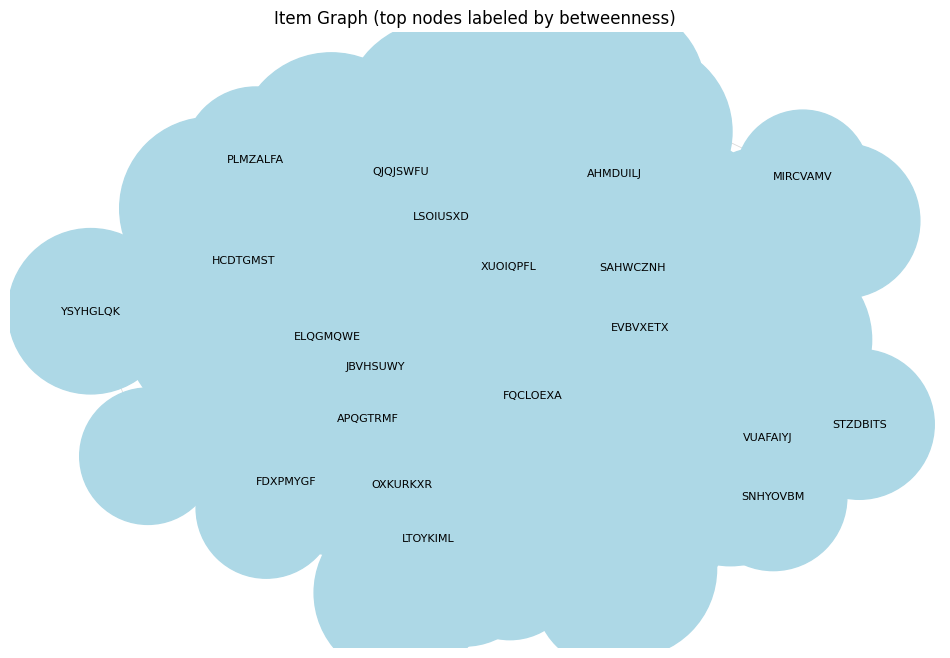

NameError: name 'W_SHORT' is not defined

In [19]:
"""
Improved EDA script for Dacon trade competition.

This script focuses purely on the raw data (train.csv) and performs:

1. **Network Construction & Centrality Analysis**
   - Uses both Pearson correlation and lagged cross‑correlation to build a directed graph
     where each node is an item_id and edges carry weights based on these statistics.
   - Applies sensible thresholds to avoid overly dense graphs and highlights the most
     influential nodes via centrality measures (in/out‑degree, closeness, betweenness).
   - Provides code to visualise this network in a way that surfaces major hubs and
     relationships. Node size is proportional to in‑degree; edge width corresponds to
     weight; node labels are only shown for the top N by betweenness to reduce clutter.

2. **Pattern Analysis Using Sign and Magnitude Categories**
   - Computes month‑to‑month differences for each item’s value time series and
     categorises these differences by both sign (+, −, 0) and magnitude (five
     categories from sharp drop to sharp rise based on quantile bins).
   - Splits each item’s time series into fixed‑length chunks (default 6 months) and
     encodes each chunk as a pattern string (e.g. '+A−B+E…').
   - Counts the frequency of each pattern across all items and identifies the most
     common patterns. This helps reveal recurring behavioural motifs in the data.
   - Computes overlap statistics between items: for each pair of items, counts
     how many patterns they share in common. Also calculates a Jaccard similarity
     (size of intersection over size of union) to normalise overlap by pattern set size.
   - Provides a simple bar chart showing the distribution of pattern lengths and
     code to tabulate the top overlaps for further investigation.

The script is intended for exploratory data analysis in a notebook environment.
It does **not** perform feature engineering or model building, but rather
provides deeper insight into the structure and dynamics of the raw data.
Use and adapt thresholds (correlation thresholds, chunk size, quantile bins)
as needed for your specific analysis.

Author: Data Engineering Team
"""

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

###############################################################################
# Utility functions for network construction
###############################################################################

def build_item_graph(train_df: pd.DataFrame,
                     corr_threshold: float = 0.3,
                     lag_threshold: float = 0.2,
                     max_lag: int = 3) -> nx.DiGraph:
    """Construct a directed graph of item relationships based on correlation and
    lagged cross‑correlation.

    Each node represents an item_id. A directed edge from i to j is added
    if either the Pearson correlation between the two series exceeds
    ``corr_threshold`` (positive or negative) or the lagged cross‑correlation
    (lead‑lag relation) exceeds ``lag_threshold``.

    Parameters
    ----------
    train_df : pd.DataFrame
        Raw training data. Must include columns 'item_id', 'date', 'value'.
    corr_threshold : float
        Minimum absolute Pearson correlation to include an edge.
    lag_threshold : float
        Minimum cross‑correlation for the lagged relationship. Only positive
        absolute values are considered.
    max_lag : int
        Maximum lag (in months) to consider when computing cross‑correlation.

    Returns
    -------
    G : nx.DiGraph
        A directed graph where nodes are item_ids and edges have a 'weight'
        attribute corresponding to correlation or lagged correlation. Edges may
        be duplicated (static and lag) if both conditions are satisfied.
    """
    # Pivot to date x item_id matrix (fill missing with 0 for correlation)
    pivot_tbl = train_df.pivot_table(
        index='date', columns='item_id', values='value', aggfunc='sum', fill_value=0
    )

    # Compute Pearson correlation between all pairs
    corr_matrix = pivot_tbl.corr()

    # Helper to compute max lagged cross‑correlation (absolute value)
    def _max_lag_corr(a: np.ndarray, b: np.ndarray) -> float:
        a_centered = a - a.mean()
        b_centered = b - b.mean()
        max_corr = 0.0
        n = len(a)
        for lag in range(1, max_lag + 1):
            if n <= lag:
                break
            corr = np.corrcoef(a_centered[:-lag], b_centered[lag:])[0, 1]
            max_corr = max(max_corr, abs(corr))
        return max_corr

    G = nx.DiGraph()
    items = corr_matrix.columns.tolist()
    # Loop over pairs of items (i -> j)
    for i, item_i in enumerate(items):
        series_i = pivot_tbl[item_i].values
        for j, item_j in enumerate(items):
            if i == j:
                continue
            series_j = pivot_tbl[item_j].values
            # static correlation weight
            w_static = corr_matrix.at[item_i, item_j]
            # Add static edge if above threshold
            if abs(w_static) >= corr_threshold:
                G.add_edge(item_i, item_j, weight=float(w_static))
            # lagged cross‑correlation weight
            w_lag = _max_lag_corr(series_i, series_j)
            if w_lag >= lag_threshold:
                G.add_edge(item_i, item_j, weight=float(w_lag))
    return G

def compute_centrality(G: nx.DiGraph) -> pd.DataFrame:
    """Compute centrality metrics for each node in the graph.

    Returns a DataFrame with columns: item_id, in_degree, out_degree,
    closeness, betweenness. The index order corresponds to the graph’s node
    list.
    """
    # In/out degree with weights
    in_deg  = dict(G.in_degree(weight='weight'))
    out_deg = dict(G.out_degree(weight='weight'))
    # Closeness and betweenness (directed)
    # For closeness, NX computes reciprocal of average length from node to others.
    closeness  = nx.closeness_centrality(G)
    betweenness= nx.betweenness_centrality(G, weight='weight')
    # Build DataFrame
    items = list(G.nodes())
    centrality_df = pd.DataFrame({
        'item_id': items,
        'in_degree': [in_deg.get(n, 0.0) for n in items],
        'out_degree':[out_deg.get(n, 0.0) for n in items],
        'closeness': [closeness.get(n, 0.0) for n in items],
        'betweenness':[betweenness.get(n, 0.0) for n in items],
    })
    return centrality_df

def draw_item_graph(G: nx.DiGraph,
                    centrality_df: pd.DataFrame,
                    top_n_labels: int = 20,
                    figsize=(12, 8)) -> None:
    """Visualise the item graph with node sizes proportional to in‑degree and
    labels for top N nodes by betweenness centrality.

    Parameters
    ----------
    G : nx.DiGraph
        The graph to visualise.
    centrality_df : pd.DataFrame
        DataFrame containing centrality metrics with item_id as nodes.
    top_n_labels : int
        Number of nodes (sorted by betweenness) to label. Others remain
        unlabeled for clarity.
    figsize : tuple
        Size of the matplotlib figure.
    """
    # Map from node index to centrality
    in_deg  = dict(zip(centrality_df['item_id'], centrality_df['in_degree']))
    between= dict(zip(centrality_df['item_id'], centrality_df['betweenness']))
    # Determine node sizes and labels
    node_sizes = [1000 * in_deg.get(n, 0.01) for n in G.nodes()]
    # Select top nodes by betweenness for labeling
    top_nodes = centrality_df.sort_values('betweenness', ascending=False)['item_id'][:top_n_labels]
    labels = {node: node if node in top_nodes.values else '' for node in G.nodes()}
    # Draw
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=0.3, seed=42)
    # Draw edges with weights determining transparency (alpha)
    weights = [abs(G[u][v]['weight']) for u, v in G.edges()]
    max_w = max(weights) if weights else 1.0
    alphas = [min(0.8, w / max_w) for w in weights]
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray', width=[2*w/max_w for w in weights], arrowsize=5)
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    plt.title("Item Graph (top nodes labeled by betweenness)")
    plt.axis('off')
    plt.show()

###############################################################################
# Utility functions for pattern analysis
###############################################################################

def categorise_diff(series: pd.Series, quantiles=None) -> pd.Series:
    """Categorise numeric differences into quintile-based bins.

    This function divides the distribution of differences into five bins:
    A (lowest ~ bottom 20%), B (20-40%), C (40-60%), D (60-80%), E (80-100%).
    Returns a series of categorical labels of equal length to the input.
    """
    if quantiles is None:
        quantiles = series.quantile([0.2, 0.4, 0.6, 0.8]).values
    # Map difference to category
    def cat(x):
        if pd.isna(x):
            return 'N'
        if x <= quantiles[0]:
            return 'A'
        elif x <= quantiles[1]:
            return 'B'
        elif x <= quantiles[2]:
            return 'C'
        elif x <= quantiles[3]:
            return 'D'
        else:
            return 'E'
    return series.apply(cat)

def compute_patterns(train_df: pd.DataFrame,
                     chunk_size: int = 6,
                     quantiles=None) -> dict:
    """Compute sign+range patterns for each item as sequences of length chunk_size.

    For each item:
    - Compute month-to-month differences in 'value' (forward difference).
    - Create two series: change_sign ('+'/'-'/ '0') and change_range (A-E) via quantile bins.
    - Combine sign and range (e.g., '+A') for each month.
    - Split this sequence into non-overlapping chunks of length ``chunk_size``.
    Returns a dictionary mapping item_id to list of pattern strings.
    """
    patterns = {}
    # Compute global quantiles if not provided
    diff_series = train_df.groupby('item_id')['value'].diff().dropna()
    if quantiles is None:
        quantiles = diff_series.quantile([0.2, 0.4, 0.6, 0.8]).values
    # Process each item
    for item, grp in train_df.groupby('item_id'):
        grp_sorted = grp.sort_values('date')
        diffs = grp_sorted['value'].diff()
        signs = diffs.apply(lambda x: '+' if x > 0 else '-' if x < 0 else '0')
        ranges = categorise_diff(diffs, quantiles=quantiles)
        # Combine into code per month
        codes = (signs.str.cat(ranges, sep='')).dropna().tolist()
        # Break into chunks
        item_patterns = []
        for i in range(0, len(codes), chunk_size):
            chunk = ''.join(codes[i:i + chunk_size])
            if len(chunk) == chunk_size:
                item_patterns.append(chunk)
        patterns[item] = item_patterns
    return patterns

def pattern_statistics(patterns: dict) -> pd.DataFrame:
    """Summarise frequency of pattern strings across all items.

    Returns a DataFrame with columns: pattern, count, proportion, and length
    (length is number of symbols, which equals chunk_size).
    """
    all_patterns = [pat for pats in patterns.values() for pat in pats]
    counts = Counter(all_patterns)
    total = len(all_patterns)
    summary = pd.DataFrame([
        {'pattern': p, 'count': c, 'proportion': c / total, 'length': len(p)}
        for p, c in counts.items()
    ]).sort_values(by='count', ascending=False).reset_index(drop=True)
    return summary

def pattern_overlap(patterns: dict,
                    top_n_pairs: int = 10) -> pd.DataFrame:
    """Compute overlap statistics between item pairs.

    For each pair of items (i, j):
    - Count the number of pattern strings in common (set intersection).
    - Compute Jaccard similarity = intersection / union (set union size).
    Returns a DataFrame sorted by intersection count (descending),
    listing top_n_pairs entries.
    """
    overlap_records = []
    items = list(patterns.keys())
    # Precompute sets
    pattern_sets = {item: set(pats) for item, pats in patterns.items()}
    for i, j in combinations(items, 2):
        set_i = pattern_sets[i]
        set_j = pattern_sets[j]
        inter = set_i & set_j
        union = set_i | set_j
        if union:
            jaccard = len(inter) / len(union)
        else:
            jaccard = 0.0
        overlap_records.append({
            'item_i': i,
            'item_j': j,
            'common_patterns': len(inter),
            'jaccard': jaccard
        })
    overlap_df = pd.DataFrame(overlap_records)
    return overlap_df.sort_values(by=['common_patterns', 'jaccard'], ascending=[False, False]).head(top_n_pairs)

def plot_pattern_length_distribution(patterns: dict, chunk_size: int) -> None:
    """Plot a histogram of pattern lengths to verify chunking consistency."""
    pattern_lengths = [len(pat) for pats in patterns.values() for pat in pats]
    plt.hist(pattern_lengths, bins=range(chunk_size - 1, chunk_size + 2), align='left', rwidth=0.5)
    plt.title('Distribution of Pattern Lengths')
    plt.xlabel('Pattern length')
    plt.ylabel('Frequency')
    plt.show()

###############################################################################
# Example usage (for a notebook environment)
###############################################################################

if __name__ == '__main__':
    # Example: load data within this script if desired
    # Note: For notebook usage, load train_df externally and call these
    # functions directly.
    import pathlib
    data_path = pathlib.Path('train.csv')
    if data_path.exists():
        train_df = pd.read_csv(data_path)
        # Ensure proper types
        train_df['item_id'] = train_df['item_id'].astype(str)
        train_df['date']    = pd.to_datetime(train_df['year'].astype(str) + '-' + train_df['month'].astype(str).str.zfill(2))
        # Build graph
        G = build_item_graph(train_df)
        centrality_df = compute_centrality(G)
        print(centrality_df.sort_values('betweenness', ascending=False).head())
        # Draw graph with top labels
        draw_item_graph(G, centrality_df)
        # Pattern analysis
        patterns = compute_patterns(train_df, chunk_size=W_SHORT)
        summary  = pattern_statistics(patterns)
        print(summary.head())
        # Plot distribution
        plot_pattern_length_distribution(patterns, W_SHORT)
        # Overlap analysis
        overlap_df = pattern_overlap(patterns)
        print(overlap_df.head())